# Association Rules & Apriori

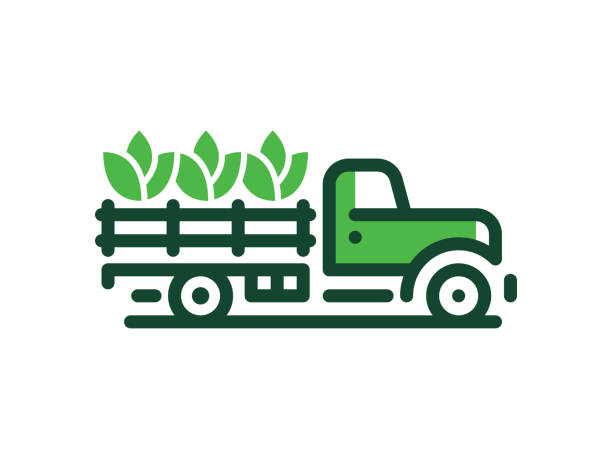

Apriori is a Machine Learning algorithm which is used to gain insight into the structured relationships between different items involved. This algorithm can be used to recommend products based on the products already present in the user’s cart

In [1]:
#imports
import pandas as pd
import numpy as np

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

import warnings
warnings.filterwarnings('ignore')

For this alogrithm I will only need to use product and order data from order_products_prior files

In [2]:
#read in files
products = pd.read_csv('data/products.csv')
order_products_prior = pd.read_csv('data/order_products__prior.csv')

In [3]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [4]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120.0,1.0,1.0
1,2,28985.0,2.0,1.0
2,2,9327.0,3.0,0.0
3,2,45918.0,4.0,1.0
4,2,30035.0,5.0,0.0


In [5]:
#creating an organic column
products['organic'] = products['product_name'].str.lower().str.contains('organic').astype(int)

In [6]:
#filtering column for only organic_products
products = products.loc[products['organic'] == 1]

First lets Create a transaction table using TransactionEncoder and then find the frequencies of orders based on the products in orders

In [7]:
# Merge dataframes and group by order_id
order_baskets = order_products_prior.merge(products, on='product_id', how='inner')
order_baskets = order_baskets.groupby('order_id')['product_name'].apply(list).reset_index()

# Create transactions with True/False values
te = TransactionEncoder()
transactions = te.fit_transform(order_baskets['product_name'])
transactions = pd.DataFrame(transactions, columns=te.columns_)
transactions['order_id'] = order_baskets['order_id']
transactions.set_index('order_id', inplace=True)

Next, we run our Apriori alogrithm for frequent itemset mining. I set the min threshhold to 0.01 so that it only returns items that appear in atleast 1% of transactions

I also sort the values by support. This says how popular an item is, as measured by the proportion of transactions in which an item appears.

In [8]:
#run the apriori alogrithm on my transaction data and filter by support from highest to lowest
frequent_items = apriori(transactions, min_support=0.01, use_colnames=True)
frequent_items.sort_values(by='support', ascending=False)

,support,itemsets
1,0.161924,(Bag of Organic Bananas)
60,0.111298,(Organic Strawberries)
8,0.102087,(Organic Baby Spinach)
34,0.089435,(Organic Hass Avocado)
4,0.073312,(Organic Avocado)
...,...,...
78,0.010604,"(Organic Hass Avocado, Organic Raspberries)"
41,0.010479,(Organic Large Grade AA Brown Eggs)
35,0.010354,(Organic Hothouse Cucumbers)
74,0.010047,"(Bag of Organic Bananas, Organic Yellow Onion)"


Now that I have my frequent items I  will run my association rules and sort them by lift from highest to lowest

Lift means Given two items, A and B, indicates whether there is a relationship between A and B, or whether the two items are occuring together in the same orders simply by chance

*   when = 1 implies items occur together only by chance
*   when > 1 implies items occur together more often than random
*   when < 1 implies items occur together less often than random

In [17]:
rules = association_rules(frequent_items, metric='lift')
rules.sort_values('support', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(Bag of Organic Bananas),(Organic Hass Avocado),0.161924,0.089435,0.025780,0.159208,1.780166,0.011298,1.082986,0.522929
3,(Organic Hass Avocado),(Bag of Organic Bananas),0.089435,0.161924,0.025780,0.288252,1.780166,0.011298,1.177489,0.481299
8,(Organic Strawberries),(Bag of Organic Bananas),0.111298,0.161924,0.025626,0.230249,1.421957,0.007604,1.088763,0.333907
9,(Bag of Organic Bananas),(Organic Strawberries),0.161924,0.111298,0.025626,0.158262,1.421957,0.007604,1.055793,0.354078
0,(Bag of Organic Bananas),(Organic Baby Spinach),0.161924,0.102087,0.021725,0.134165,1.314219,0.005194,1.037048,0.285286
1,(Organic Baby Spinach),(Bag of Organic Bananas),0.102087,0.161924,0.021725,0.212804,1.314219,0.005194,1.064634,0.266275
6,(Bag of Organic Bananas),(Organic Raspberries),0.161924,0.057914,0.017405,0.107487,1.855989,0.008027,1.055544,0.550312
7,(Organic Raspberries),(Bag of Organic Bananas),0.057914,0.161924,0.017405,0.300529,1.855989,0.008027,1.198157,0.489556
23,(Organic Hass Avocado),(Organic Strawberries),0.089435,0.111298,0.016638,0.186039,1.671535,0.006684,1.091824,0.441207
22,(Organic Strawberries),(Organic Hass Avocado),0.111298,0.089435,0.016638,0.149493,1.671535,0.006684,1.070615,0.452061


Lets create simpler dataframe of antecendents and consequents (i.e if this then this)

Since Bag of Organic Bananas is the one item that appears the most in orders it has the greatest number of associations.

In the targeted rules dataframe below we can see what items to recommend when someone is purchasing a Bag of Organic Bananas

Or see when to recommend a Bag of Organic Bananas based one a customer ordering Organic Baby Spinach, Avocados, Raspberries, Strawberries and Whole Milk

In [13]:
#creating a filterd dataframe to easily see what items are paired with Bananas
targeted_rules_b = rules[rules['antecedents']=={'Bag of Organic Bananas'}].copy()
targeted_rules_b.sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
6,(Bag of Organic Bananas),(Organic Raspberries),0.161924,0.057914,0.017405,0.107487,1.855989,0.008027,1.055544,0.550312
2,(Bag of Organic Bananas),(Organic Hass Avocado),0.161924,0.089435,0.025780,0.159208,1.780166,0.011298,1.082986,0.522929
5,(Bag of Organic Bananas),(Organic Lemon),0.161924,0.037318,0.010005,0.061790,1.655779,0.003963,1.026084,0.472576
9,(Bag of Organic Bananas),(Organic Strawberries),0.161924,0.111298,0.025626,0.158262,1.421957,0.007604,1.055793,0.354078
12,(Bag of Organic Bananas),(Organic Yellow Onion),0.161924,0.047017,0.010047,0.062048,1.319710,0.002434,1.016026,0.289064
0,(Bag of Organic Bananas),(Organic Baby Spinach),0.161924,0.102087,0.021725,0.134165,1.314219,0.005194,1.037048,0.285286
10,(Bag of Organic Bananas),(Organic Whole Milk),0.161924,0.056757,0.011427,0.070568,1.243334,0.002236,1.014860,0.233524


In [14]:
#creating a filterd dataframe to easily see what items are paired with Strawberries
targeted_rules_s = rules[rules['antecedents']=={'Organic Strawberries'}].copy()
targeted_rules_s.sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
24,(Organic Strawberries),(Organic Raspberries),0.111298,0.057914,0.013712,0.123200,2.127308,0.007266,1.074460,0.596288
22,(Organic Strawberries),(Organic Hass Avocado),0.111298,0.089435,0.016638,0.149493,1.671535,0.006684,1.070615,0.452061
8,(Organic Strawberries),(Bag of Organic Bananas),0.111298,0.161924,0.025626,0.230249,1.421957,0.007604,1.088763,0.333907
18,(Organic Strawberries),(Organic Baby Spinach),0.111298,0.102087,0.016137,0.144986,1.420210,0.004774,1.050172,0.332934
